# Imports

In [7]:
%matplotlib ipympl

RuntimeError: 'ipympl is not a recognised GUI loop or backend name

In [8]:
%pip install pandas
%pip install seaborn
%pip install sklearn
%pip install scikit-learn
%pip install ipywidgets


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, se

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import pow
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import math
import os
from sklearn.metrics import r2_score
from ipywidgets import IntProgress
import scipy.optimize as opt
# sns.set_theme()

# Data Loading & Processing
From the Grim IREC flight

In [10]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [11]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

# Virtual Telemetry
- getting AGL and ASL altitude from pressure

In [12]:
boost_end = 3_500
first_charge = 28_125

In [13]:
altim = df[['pressure (kPa)']].copy()

In [14]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

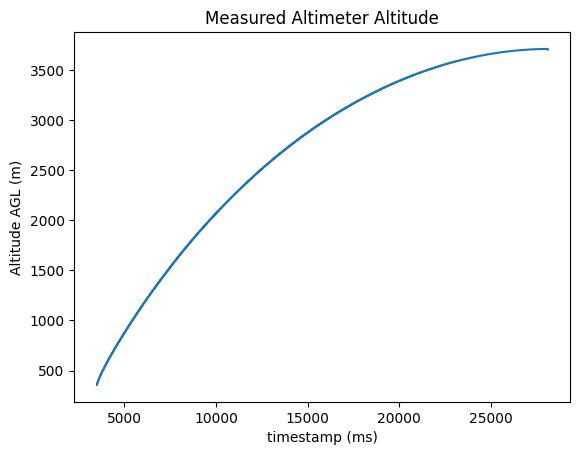

In [15]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

In [18]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

# Helpers

In [17]:
def save(in_pattern: str, outfile: str, framerate: int, extra_args: str = ""):
    os.system(f"ffmpeg -framerate {framerate} -i {in_pattern} {extra_args} -y {outfile}")

# Fitting a parabola

## Global Fit

In [12]:
poly = np.polyfit(nice_data.index, nice_data['alt_m_agl'], 2)
print(poly)

def par_fit(x):
    return poly[0] * x * x + poly[1] * x + poly[2]

[  -5.97525396  317.51082755 -540.46277832]


In [13]:
xs = np.linspace(boost_end/1000, first_charge/1000, 1000)

In [14]:
ys = par_fit(xs)

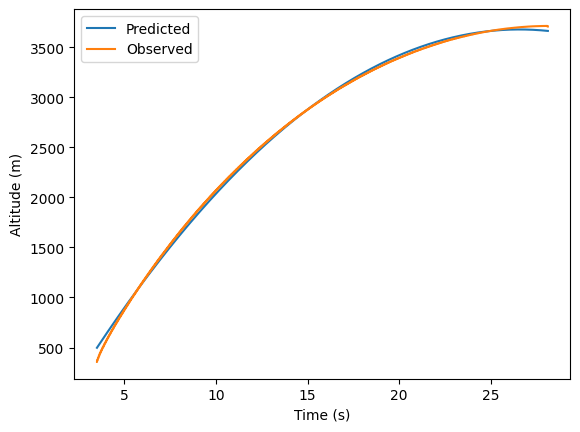

In [15]:
p = sns.lineplot(x=xs, y =ys, label = "Predicted")
p.plot(nice_data['alt_m_agl'], label = "Observed")
p.set_xlabel("Time (s)")
p.set_ylabel("Altitude (m)")
p.legend();

# Digging deep into parabola

In [19]:
endpoint_num = 40
endpoints = np.linspace(boost_end/1000+0.5, first_charge/1000, endpoint_num)
pts = pd.DataFrame(endpoints, columns=["time"])

In [30]:
endpoint_num = 100
endpoints = np.linspace(boost_end/1000+0.5, first_charge/1000, endpoint_num)
pts = pd.DataFrame(endpoints, columns=["time"])
actual_apogee = nice_data.alt_m_agl.max()

In [33]:

nice_data.iloc[nice_data.alt_m_agl.argmax()]

pressure (kPa)      53.967930
alt_m_asl         5005.111438
alt_m_agl         3712.883704
Name: 28.056, dtype: float64

In [41]:
degree = 2
def do_thing_before(t):
    data = nice_data.loc[:t]

    poly = np.polyfit(data.index, data['alt_m_agl'], degree)
    predictor = np.poly1d(poly)
    prediction = predictor(nice_data.index)
    
    ap_inde = prediction.argmax()
    apogee_time_pred = nice_data.iloc[ap_inde].name
    apogee_height_pred = prediction[ap_inde]
    time_to_pred_apogee = apogee_time_pred - t

    return [poly[0], poly[1], poly[2], apogee_time_pred, apogee_height_pred, time_to_pred_apogee]
pts[['e2', 'e1', 'e0', 'apogee_time_pred', 'apogee_height_pred', 'time_to_pred_apogee']] = pts.apply(lambda row : do_thing_before(row.time), axis='columns', result_type='expand')

In [42]:
maxes = pts.abs().max()
pts[['n2', 'n1', 'n0']] = pts.apply(lambda row : [row.e2/maxes.e2, row.e1/maxes.e1, row.e0/maxes.e0], axis='columns', result_type='expand')

<Axes: title={'center': 'Coeffecients'}, xlabel='Time (s)', ylabel='Height (m)'>

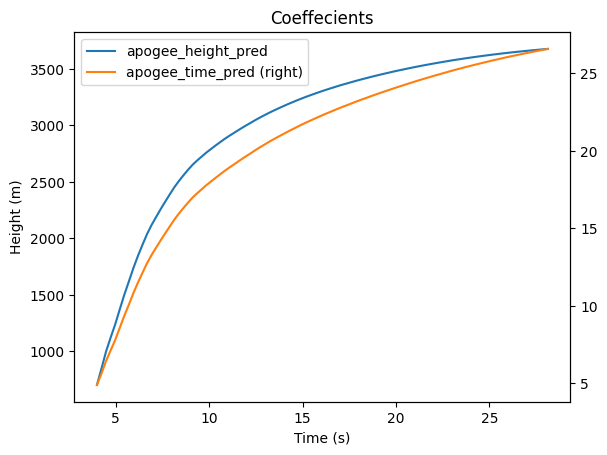

In [44]:
pts['apogee_time_pred']
f = pts[['apogee_height_pred', 'apogee_time_pred']].set_index(pts['time']).iloc[:].plot(secondary_y='apogee_time_pred')
f.set_title("Coeffecients")
f.set_xlabel("Time (s)")
f.set_ylabel("Height (m)");
f

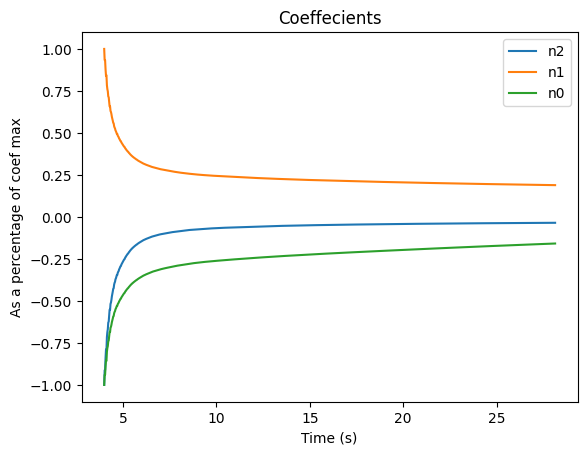

In [32]:
f = pts[['n2', 'n1', 'n0']].set_index(pts['time']).iloc[:].plot()
f.set_title("Coeffecients")
f.set_xlabel("Time (s)")
f.set_ylabel("As a percentage of coef max");

In [34]:
# endpoint_num = 1000
# endpoints = np.linspace(boost_end/1000+0.1, first_charge/1000, endpoint_num)
# pts = pd.DataFrame(endpoints, columns=["time"])

In [35]:
# pts[['e2', 'e1', 'e0']] = pts.apply(lambda row : do_thing_before(row.time), axis='columns', result_type='expand')
# maxes = pts.abs().max()
# pts[['n2', 'n1', 'n0']] = pts.apply(lambda row : [row.e2/maxes.e2, row.e1/maxes.e1, row.e0/maxes.e0], axis='columns', result_type='expand')

In [34]:
actual_apogee

np.float64(3712.8837039159207)

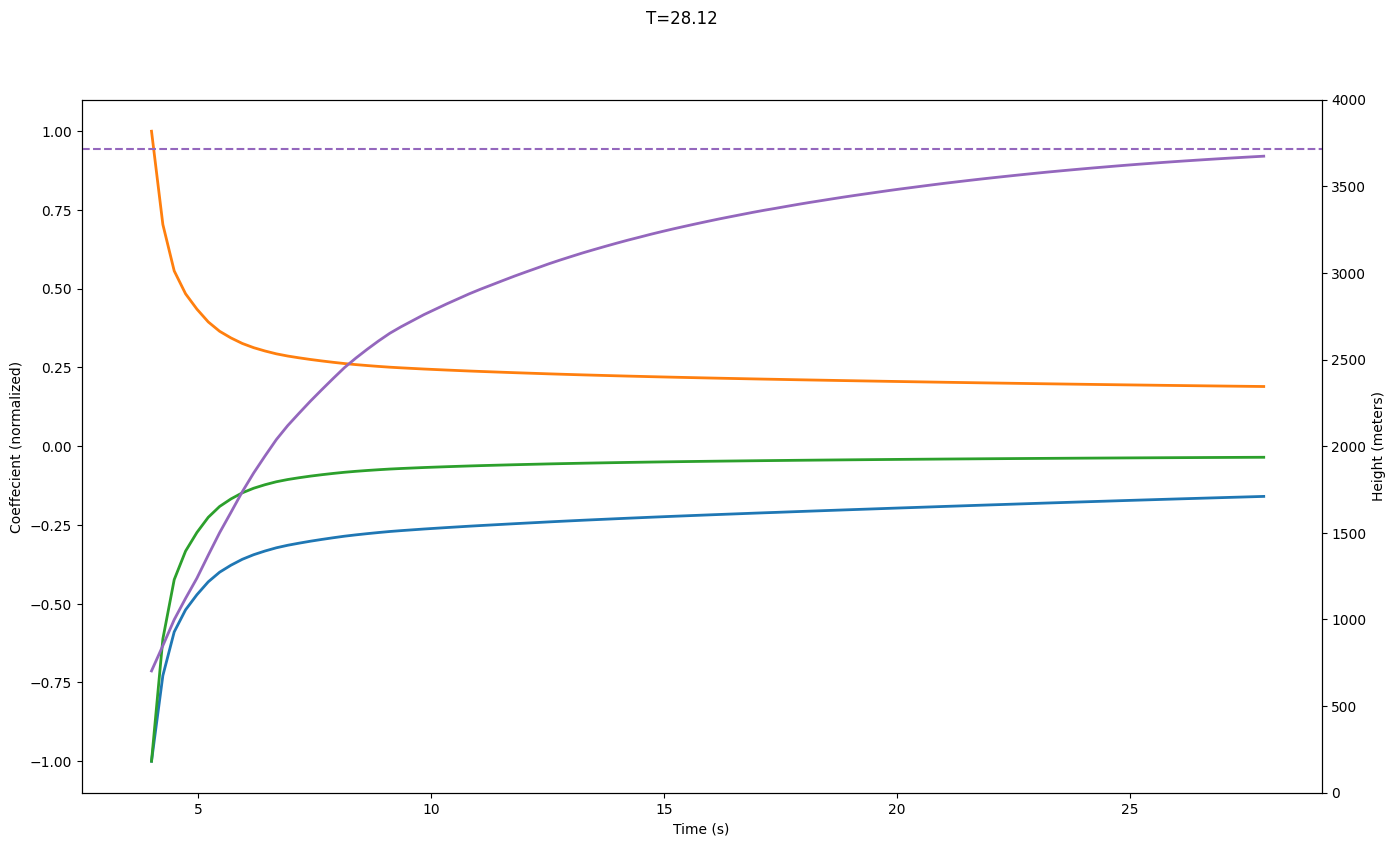

In [63]:
# creating a blank window 
# for the animation  
fig = plt.figure(figsize=(16,9))  
axis = plt.axes(xlim =(boost_end/1000 - 1, first_charge/1000 + 1), 
                ylim =(-1.1, 1.1))  

axis.set_xlabel("Time (s)")
axis.set_ylabel("Coeffecient (normalized)")
line0, = axis.plot([], [], lw = 2, label = "e0")  
line1, = axis.plot([], [], lw = 2, label = "e1")  
line2, = axis.plot([], [], lw = 2, label = "e2")  

sy = axis.twinx()  
sy.set_ylim(0, 4000)
sy.axhline(actual_apogee, c='C4', linestyle='dashed')
sy.set_ylabel("Height (meters)")


apogee_pred_time = axis.axhline(12.5)
# print(apogee_pred_time.get_data())
# return

line_apo, = sy.plot([], [], lw=2, c = 'C4')
def init():  
    line0.set_data([], [])  
    line1.set_data([], [])  
    line2.set_data([], [])  
    line_apo.set_data([], [])
    apogee_pred_time.set_data([], [])
    return line1, line1, line2, line_apo

# animation function  
def animate(i):  


    latest = pts.iloc[i]
    t = latest.time

    fig.suptitle(f"T={t:.2f}")

    dat = pts.iloc[:i]
    xs = dat.time

    line0.set_data(xs, dat.n0)
    line1.set_data(xs, dat.n1)
    line2.set_data(xs, dat.n2)
      
    line_apo.set_data(xs, dat.apogee_height_pred)  

    apogee_pred_time.set_data([0,1], [latest['apogee_time_pred'], latest['apogee_time_pred']])
    
    return line0, line1, line2, line_apo
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = len(pts), blit = True)  
   
# saves the animation in our desktop 
anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 60) 


<Axes: >

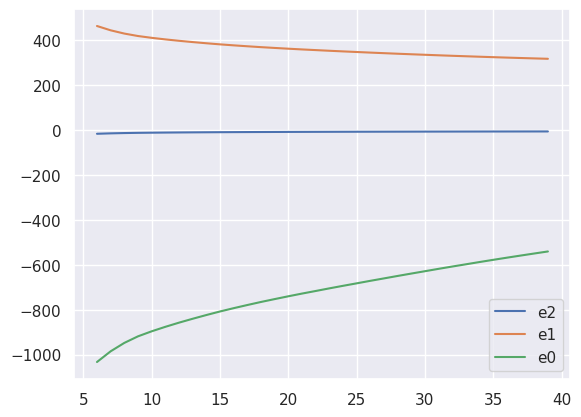

In [ ]:
pts[['e2', 'e1', 'e0']].iloc[6:].plot()

In [ ]:
coefs.plot()

TypeError: no numeric data to plot

In [ ]:
f = sns.lineplot(x=xs, y=predicted_apogees)
f.set_xlabel("Time (s)")
f.set_ylabel("Predicted apogee (m)")
f.set_title("Parabola Predicted Apogee")
f.set_ybound(-100, 4000)
apogee = nice_data['alt_m_agl'][apogee_x]
print(apogee)
apogees = [apogee] * len(xs)
errs = list(map(lambda t : abs(t[0] - t[1]), zip(apogees, predicted_apogees)))
sy = f.twinx()
sy.set_ylim(0,4_000)
sy.plot(xs, errs, c = 'C1')
sy.set_ylabel("Apogee Error (m)")
f.axhline(apogee, c="C3")
print(apogee)

NameError: name 'predicted_apogees' is not defined

## Fit Window

In [ ]:
endpoint_num = 40
endpoints = np.linspace(boost_end/1000+0.1, first_charge/1000, endpoint_num)

In [ ]:
apogee_x = nice_data['alt_m_agl'].idxmax()
frame = 0
for end in endpoints:
    data = nice_data.loc[end - 1 :end]
    times = nice_data.index.to_series()

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    prediction = predictor(times)

    plt.figure(figsize=(16,9))

    p = sns.lineplot(x=times, y =prediction, label = "Predicted Altitude", dashes=(1,1), linewidth=3)
    p.plot(data['alt_m_agl'], label = "Observed Altitude", linewidth=3, alpha = 0.75, c='C2')

    p.set_xlim(0, 32)
    p.set_ylim(0, 4000)

    p.set_xlabel("Time (s)")
    p.set_ylabel("Altitude (m)")

    predicted_apogee = times.iloc[prediction.argmax()]

    p.axvline(apogee_x, c='C3', label = f"Actual Apogee: {apogee_x:.2f}s", dashes=(2,2))
    p.axvline(predicted_apogee, label = f"Predicted Apogee: {predicted_apogee:.2f}s", c= 'C4', dashes=(2,2))
    
    r2 = r2_score(data['alt_m_agl'], prediction[:len(data)])
    p.get_figure().suptitle(f"Grim Altimeter Parabola Fitting with Window: T+{end:.2f}s")
    
    p.set_title(f"{poly[0]:.2f}x^2 + {poly[1]:.2f}x + {poly[2]:.2f}        R^2 = {r2:.5f}")
    p.legend(loc="upper left")
    
    plt.savefig(f"intermediate_data/windowed_fitting/{frame:03}.png");
    plt.close()

    frame+=1

In [ ]:
save("intermediate_data/windowed_fitting/%03d.png" , "intermediate_data/WindowedFit.mp4", 60, extra_args = "-vf tpad=stop_mode=clone:stop_duration=2")

ffmpeg version n7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.1.1 (GCC) 20240522
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enab

## Projectile Motion Prediction 

In [20]:
pred_data = nice_data.copy()

In [24]:
pt2_ind = 250
delta_pos = pred_data.iloc[pt2_ind] - pred_data.iloc[0]
delta_t = pred_data.iloc[pt2_ind].name - pred_data.iloc[0].name
initial_velocity = delta_pos / delta_t
initial_pos = pred_data.iloc[0]

In [35]:
initial_pos

pressure (kPa)      83.018967
alt_m_asl         1648.553042
alt_m_agl          356.325308
Name: 3.502, dtype: float64

In [ ]:
import math

In [ ]:
initial_velocity * math.tan(math.radians(90-88))

pressure (kPa)    -0.181866
alt_m_asl         17.861870
alt_m_agl         17.861870
dtype: float64

In [ ]:
def projectile(realt):
    t = realt-boost_end/1000
    return initial_pos['alt_m_agl'] + initial_velocity['alt_m_agl'] * t - .5 * 9.8 * t * t

In [ ]:
pred_data['projectile_m_agl'] = pred_data.index.to_series().map(projectile)

In [ ]:
renamed = pred_data[['projectile_m_agl', 'alt_m_agl']].rename(columns={"alt_m_agl":"Altitude AGL", "projectile_m_agl": "Projectile Prediction"})

Text(0, 0.5, 'Altitude (m)')

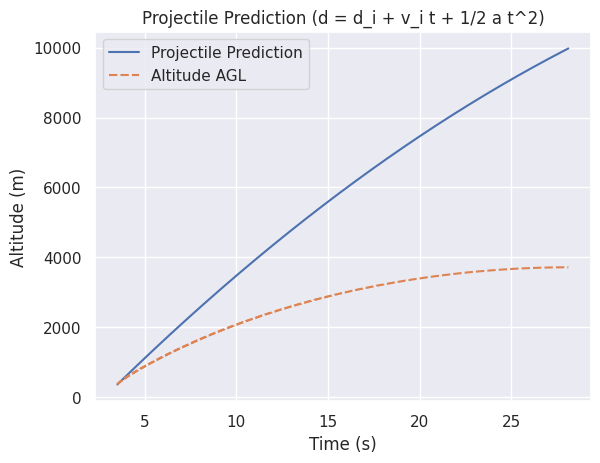

In [ ]:
p = sns.lineplot(renamed)
p.set_title("Projectile Prediction (d = d_i + v_i t + 1/2 a t^2)")
p.set_xlabel("Time (s)")
p.set_ylabel("Altitude (m)")


# Drag From IMU

We only care about the going up side of things and can (maybe) assume we are 1d going up. Since we're only going up, all acceleration is slowing us down (going in the same direction)

We feel like we're in freefall even while going up so all measured accelelration is drag, can try to figure out drag from that

> Note!
> Dont run your buzzer while measuring the imu lmao

filter out repeats and lerp altitude to get smoothness

In [142]:
nice_altim = altim['alt_m_agl'].copy()
# display(nice_altim)
nice_altim = nice_altim.mask((nice_altim.shift(1) == nice_altim)).interpolate()

In [143]:
nice_imu = df.loc[boost_end:first_charge][['accx (m/s^2)','accy (m/s^2)','accz (m/s^2)']].copy()
nice_imu['agl_m'] = nice_altim
nice_imu.index = nice_imu.index.map(lambda ms : ms / 1000.0)


In [144]:
nice_imu[['sx', 'sy', 'sz']] = nice_imu[['accx (m/s^2)', 'accy (m/s^2)', 'accz (m/s^2)']].rolling(window=100, center=True).mean()
nice_imu['mag'] = np.sqrt(nice_imu.sx**2 + nice_imu.sy**2 + nice_imu.sz**2)
nice_imu.dropna(inplace=True)

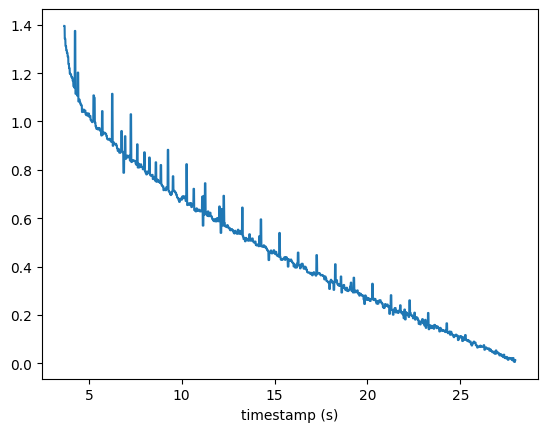

In [155]:

grad_base = pd.Series(np.gradient(nice_imu['agl_m']), nice_imu.index, name='slope')
grad_base.index.rename("timestamp (s)", inplace=True)
grad = grad_base[grad_base !=0].plot()


In [154]:
(906.950265 - 452.813117) / (5.087 - 3.677) 

322.0830836879433

In [153]:
nice_imu['agl_m'].head(400)

timestamp (s)
3.677    452.813117
3.681    454.208283
3.684    455.603448
3.688    456.998614
3.692    458.393779
            ...    
5.072    902.857598
5.076    903.880765
5.079    904.903932
5.083    905.927099
5.087    906.950265
Name: agl_m, Length: 400, dtype: float64

<Axes: xlabel='timestamp (s)'>

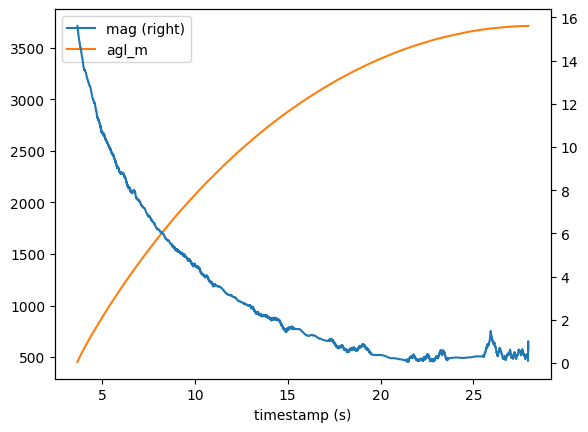

In [156]:
nice_imu[['mag', 'agl_m']].plot(secondary_y='mag')

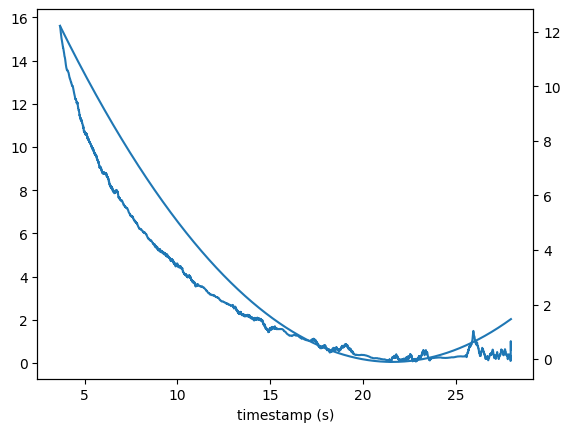

In [171]:
params = np.polyfit(nice_imu.index, nice_imu.mag, deg = 2)
poly = np.poly1d(params)
prediction = poly(nice_imu.index)
predi

f = nice_imu.mag.plot()
f.twinx().plot(nice_imu.index, prediction)

6893


/tmp/ipykernel_15625/2820650679.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


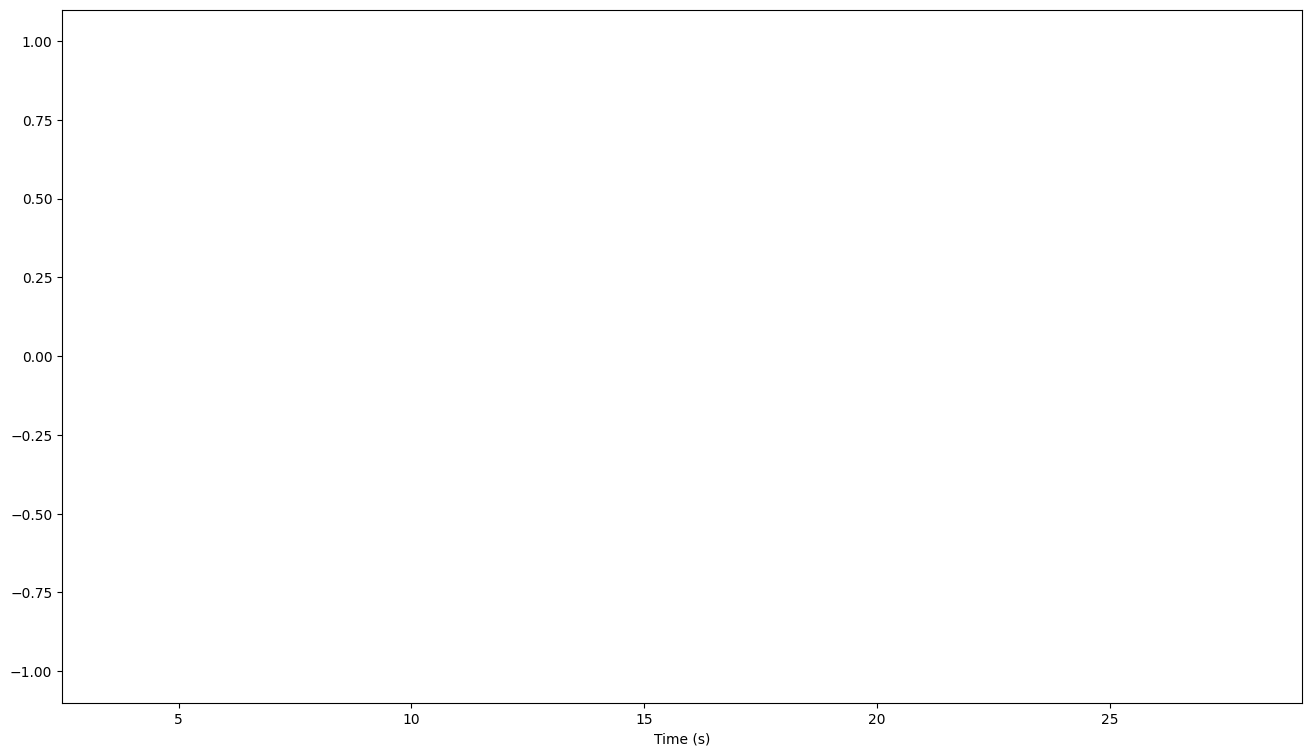

In [186]:
# creating a blank window 
# for the animation  
fig = plt.figure(figsize=(16,9))  
axis = plt.axes(xlim =(boost_end/1000 - 1, first_charge/1000 + 1), 
                ylim =(-1.1, 1.1))  

axis.set_xlabel("Time (s)")
# axis.set_ylabel("Coeffecient (normalized)")
line0, = axis.plot([], [], lw = 2, label = "e0")  
# line1, = axis.plot([], [], lw = 2, label = "e1")  
# line2, = axis.plot([], [], lw = 2, label = "e2")  

# sy = axis.twinx()  
# sy.set_ylim(0, 4000)
# sy.axhline(actual_apogee, c='C4', linestyle='dashed')
# sy.set_ylabel("Height (meters)")


# apogee_pred_time = axis.axhline(12.5)
# print(apogee_pred_time.get_data())
# return

# line_apo, = sy.plot([], [], lw=2, c = 'C4')
def init():  
    line0.set_data([], [])  
    # line1.set_data([], [])  
    # line2.set_data([], [])  
    # line_apo.set_data([], [])
    # apogee_pred_time.set_data([], [])
    return line0,
    # return line1, line1, line2, line_apo

# animation function  
def animate(i):
    latest = nice_imu.iloc[i]
    t = latest.time

    fig.suptitle(f"T={t:.2f}")

    dat = nice_imu.iloc[:i]
    xs = dat.index

    line0.set_data(xs, dat.mag)
    # line1.set_data(xs, dat.n1)
    # line2.set_data(xs, dat.n2)
      
    # line_apo.set_data(xs, dat.apogee_height_pred)  

    # apogee_pred_time.set_data([0,1], [latest['apogee_time_pred'], latest['apogee_time_pred']])
    
    return line0, #, line1, line2, line_apo
   
print(len(nice_imu))
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = len(nice_imu), blit = True)


In [ ]:
anim.save('dragFit.mp4', writer = 'ffmpeg', fps = 60) 

In [36]:
from scipy.interpolate import splrep, BSpline

In [38]:
xs = nice_data.index.to_series()
ys = nice_data.alt_m_agl

In [68]:
%pip install gplearn

  Using cached gplearn-0.4.2-py3-none-any.whl.metadata (4.3 kB)
Using cached gplearn-0.4.2-py3-none-any.whl (25 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
import gplearn

In [76]:
import gplearn.genetic

est_gp = gplearn.genetic.SymbolicRegressor(verbose=1)


In [101]:
xnp = np.ndarray((1,len(xs)), buffer = xs.to_numpy())
xnp

array([[ 3.502,  3.506,  3.509, ..., 28.116, 28.12 , 28.123]])

In [104]:
nice_data['t'] = nice_data.index.to_series()

In [107]:
import sklearn.model_selection

In [108]:

X = nice_data[['t']]
y = nice_data['alt_m_agl']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)


In [113]:
# First Test
function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv']
est_gp = gplearn.genetic.SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=40, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          feature_names=X_train.columns)

In [115]:
est_gp.fit(X_train, y_train)
print('R2:',est_gp.score(X_test,y_test))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.94          3153.04       23          794.452          764.193      5.92m
   1    19.07          3400.56       36          428.327          433.193      3.47m
   2    30.12          10982.1        9          341.961          326.274      4.14m
   3    29.67          43539.8       43          325.523          330.708      4.07m
   4    32.42           137999       54          323.998           338.08      3.88m
   5    40.92           167516       40          265.525           252.06      4.46m
   6    49.04            28950       41          226.992          214.563      4.99m
   7    50.35          13015.5       51          222.513          240.381      4.99m
   8    50.20            14566       97          220.826          221.418  

NameError: name 'sympify' is not defined

In [116]:
%pip install sympy
import sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 25.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 39.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [135]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : math.sin(x),
    'cos': lambda x    : math.cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

In [136]:
print(str(est_gp._program))
sympy.sympify(str(est_gp._program), locals=converter)

add(mul(sub(neg(div(0.470, 0.015)), cos(mul(0.395, t))), sub(sub(sub(sub(neg(div(0.470, 0.015)), cos(mul(0.395, t))), cos(mul(0.395, t))), cos(mul(0.395, t))), cos(0.654))), add(sub(sub(sin(inv(inv(t))), div(t, -0.008)), div(sub(div(neg(div(neg(div(neg(div(neg(mul(inv(-0.704), inv(-0.034))), sub(neg(inv(div(sub(div(neg(div(neg(mul(-0.051, -0.395)), inv(-0.536))), inv(sub(div(neg(0.224), mul(-0.051, -0.395)), mul(inv(-0.313), div(-0.029, 0.685))))), mul(inv(div(inv(inv(0.644)), inv(inv(div(t, -0.008))))), inv(-0.034))), sin(inv(div(t, -0.008)))))), div(-0.029, 0.685)))), neg(sub(0.540, t)))), add(mul(-0.287, -0.096), inv(-0.791)))), inv(sub(div(neg(0.224), mul(-0.051, -0.395)), mul(inv(0.517), div(t, 0.368))))), inv(-0.313)), add(t, t))), div(t, -0.697)))


TypeError: Cannot convert expression to float

In [146]:
add = lambda x, y : x + y
sub = lambda x, y : x - y
mul = lambda x, y : x * y
div = lambda x, y : x / y
neg = lambda x : -x
cos = math.cos
sin = math.sin
inv = lambda x : 1 / x

In [147]:
pred = lambda t : add(mul(sub(neg(div(0.470, 0.015)), cos(mul(0.395, t))), sub(sub(sub(sub(neg(div(0.470, 0.015)), cos(mul(0.395, t))), cos(mul(0.395, t))), cos(mul(0.395, t))), cos(0.654))), add(sub(sub(sin(inv(inv(t))), div(t, -0.008)), div(sub(div(neg(div(neg(div(neg(div(neg(mul(inv(-0.704), inv(-0.034))), sub(neg(inv(div(sub(div(neg(div(neg(mul(-0.051, -0.395)), inv(-0.536))), inv(sub(div(neg(0.224), mul(-0.051, -0.395)), mul(inv(-0.313), div(-0.029, 0.685))))), mul(inv(div(inv(inv(0.644)), inv(inv(div(t, -0.008))))), inv(-0.034))), sin(inv(div(t, -0.008)))))), div(-0.029, 0.685)))), neg(sub(0.540, t)))), add(mul(-0.287, -0.096), inv(-0.791)))), inv(sub(div(neg(0.224), mul(-0.051, -0.395)), mul(inv(0.517), div(t, 0.368))))), inv(-0.313)), add(t, t))), div(t, -0.697)))


In [148]:
pred(0)

ZeroDivisionError: division by zero

# time integrate silly
iniitial error
model that minimizes error^2 over time

In [48]:
from scipy import interpolate

In [63]:
spline = interpolate.UnivariateSpline(xs, ys)

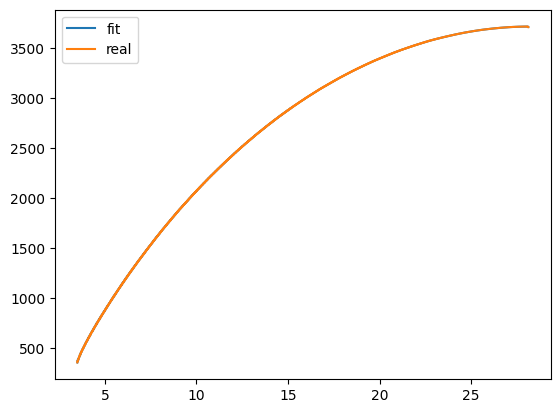

In [64]:
plt.plot(xs, spline(xs), label = "fit")
plt.plot(xs, ys, label = "real")
plt.legend()

In [39]:
tck = splrep(xs, ys, s=0)
tck_s = splrep(xs, ys, s=len(xs))

In [47]:
len(tck[0])

6996

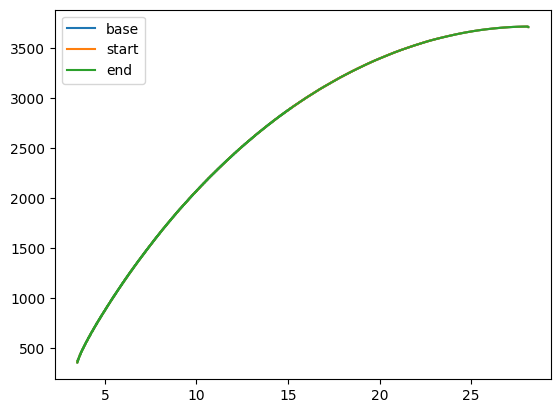

In [45]:
plt.plot(xs, ys, label = "base")
plt.plot(xs, BSpline(*tck)(xs), label = "start")
plt.plot(xs, BSpline(*tck_s)(xs), label = "end")
plt.legend()